# INFO-4604 Final Project
#### By Albert Dayn and Galen Pogoncheff

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.learning_curve import learning_curve
import matplotlib.pylab as plt 
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## Introduction

$\quad$ For our project, we decided to apply machine learning to a bicycling dataset.  This data set is composed of statistical data (such as total distance, elevation gain, average speed, etc.) regarding individual bicycle rides that Galen has completed over the past year.  This data was obtained with a garmin gps computer.  The data set is composed of 108 bicycle rides in total, 48 of which were mountain bike rides and 60 road bike rides.  Each instance of the data set is a single bicycle ride, with the ride statistics as features.  Our goal for this final project was to build a machine learning model to classify a bicycle ride as either a mountain bike ride or a road bike ride.

## Data Preprocessing

$\quad$ Extracting our dataset from the garmin device was straightforward.  After uploading the data from the Garmin GPS unit to Garmin's own web application, we were able to export all of the data to a csv file.  A subset of the csv file is shown below:

In [3]:
dfRawData = pd.read_csv('./rawData.csv', encoding='latin1')
dfRawData.head()

,Activity Type,Date,Favorite,Title,Distance,Calories,Time,Avg HR,Max HR,Aerobic TE,...,Max Depth,Bottom Time,Min Water Temp,Gas Type,Surface Interval,Weight,Current,Surface Conditions,Decompression,Water Type
0,cycling,10/25/17 7:42,False,Boulder Cycling,13.06,534,59:00:00,--,--,0,...,--,0:00,0,--,0:00,--,--,--,No,--
1,cycling,10/21/17 16:04,False,Boulder Cycling,13.89,571,1:01:56,--,--,0,...,--,0:00,0,--,0:00,--,--,--,No,--
2,cycling,10/15/17 15:10,False,Boulder Cycling,15.29,640,1:09:50,--,--,0,...,--,0:00,0,--,0:00,--,--,--,No,--
3,cycling,10/8/17 16:29,False,Boulder Cycling,14.51,610,1:05:43,--,--,0,...,--,0:00,0,--,0:00,--,--,--,No,--
4,cycling,9/15/17 7:45,False,Boulder Cycling,21.34,841,1:43:18,--,--,0,...,--,0:00,0,--,0:00,--,--,--,No,--


$\quad$ The first step we took in the data preprocessing phase was annotating the data, making each ride instance as a mountain bike ride or a road bike ride.  This annotation performed by looking at the mapped route (on Garmin's web UI) for each ride instance, and determining if it was a mountain or road bike ride based off of the route of that instance.  As we are very familiar with these routes, this was a direct approach to obtain accurate annotations for each instance.  Class labels were assigned as 1 if the ride was a mountain bike ride, and 0 if it was a road bike ride.<br>
$\quad$ Following the data annotation phase we performed some initial feature selection.  We removed features from  our data were insignificant (for example, the 'Activity Type' feauture had a category value of 'cycling' for every feature, the 'Date' feature would be invaluable for predicting new data, and the 'Title' feature (which denoted the ride location) would not be useful in the classification of bike rides in new locations that have been unseen by the classifier) or had empty values for most if not all features.  The following dataframe shows a subset of the dataset after data annotation and an initial pass of feature selection were performed:

In [4]:
pd.read_csv('./garminData_annotated.csv').head()

,Distance,Calories,Time,Avg Speed,Max Speed,Elev Gain,Elev Loss,isMountainBiking
0,13.06,534,59:00:00,13.3,26.4,"1,106","1,109",1
1,13.89,571,1:01:56,13.5,25.6,"1,293","1,259",1
2,15.29,640,1:09:50,13.1,30,"1,542","1,547",1
3,14.51,610,1:05:43,13.2,28.8,"1,534","1,503",1
4,21.34,841,1:43:18,12.4,30.2,"3,146","3,128",1


$\quad$ In the dataset, there were two instances that missing values for the 'Calories' feature.  Since there were so few instances with missing data, we decided that it was in our best interest to drop the instances from the dataset as opposed to imptuting the missing values.<br>
$\quad$ The final data preprocessing actions that we had to perform involved converting the 'Time' feature to a value that could be used in a machine learning algorithm and removing the commas from the 'Elev Gain' and 'Elev Loss' features so that they would be interpreted as numbers instead of strings. A subset of our final preprocessed dataset is provided below:

In [5]:
pd.read_csv('./garminDataFinal.csv').head()

,Distance (Miles),Calories,Time (minutes),Avg Speed,Max Speed,Elev Gain,Elev Loss,isMountainBiking
0,13.06,534.0,59.000,13.3,26.4,1106.0,1109.0,1
1,13.89,571.0,61.933,13.5,25.6,1293.0,1259.0,1
2,15.29,640.0,69.833,13.1,30.0,1542.0,1547.0,1
3,14.51,610.0,65.717,13.2,28.8,1534.0,1503.0,1
4,21.34,841.0,103.300,12.4,30.2,3146.0,3128.0,1


## Model Selection

$\quad$ In selecting the classifier that we would ultimately choose for our finalized model, we decided to experimented with one linear classifier, one non-liner ensemble classifier, and a neural network classifier.  The specific classifers that we chose to experiment with for each of these categories of classifiers were a logistic regression classifier, a random forest classifier, and a multilayer perceptron classifier, respectively.<br>
$\quad$ Prior to experimenting with these classifier, we divided our dataset into a training dataset and a testing dataset.  A testing dataset was formed by removing 20% of the instances, at random, from the original dataset.  The traing dataset we used was therefore the remaining 80% of the instances.

In [5]:
dfData = pd.read_csv('./garminDataFinal.csv')

# select a random sample of data for testing
dfTest = dfData.sample(frac=0.2, replace=False, random_state=123)

# remove test data from original data to form the training dataset
dfTrain = dfData.drop(dfTest.index)

In [6]:
# separating features from labels in the training dataset
x_train = dfTrain.iloc[0:, 0:7].values
y_train = dfTrain.iloc[0:, 7].values

# separating features from labels in the test dataset
x_test = dfTest.iloc[0:, 0:7].values
y_test = dfTest.iloc[0:, 7].values

### Experimenting with Logistic Regression

$\quad$ Our first classifier experimentation was done with a logistic regression classifier.  We tuned out model by finding an optimal value for  the regularization strength term, alpha.  Multiple values of alpha (0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0) were evaluated by doing a grid search over these hyperparameter values.  We also experimented with dimensionality reduction by means of Priniple Component Analysis (PCA).  Tuning our classifier with various values of alpha and components of PCA in the (range 1-7) involved finding the optimal value for alpha for each value of number of components in PCA.  In order to obtain robust estimates of accuracy on our held out test data set, we performed model selection in the context of 5-fold cross validation. The code for our logistic regression classifier and results of this experimentation are below:

In [51]:
base_classifier = SGDClassifier(loss='log', max_iter=1000, tol=1.0e-12, random_state=123)

params = [{'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}]

# performs 5-fold cross-validation with a logistic regression classifier, doing a grid search over alpha
gs_classifier = GridSearchCV(base_classifier, params, cv=5)

# number of axes for principle component analysis
numComponents = np.arange(1,8)

validationAccuracies = []

print("| Number of Components |   Alpha   | Validation Accuracy |")
print("|----------------------|-----------|---------------------|")
for n in numComponents:
    pca = PCA(n_components=n, random_state=123)
    x_train_final = pca.fit_transform(x_train)
    x_test_final = pca.transform(x_test)
    gs_classifier.fit(x_train_final, y_train)
    validAcc = gs_classifier.best_score_
    validationAccuracies.append(validAcc)
    print("|{:^22}|{:^11}|{:^21}|".format(n, gs_classifier.best_params_['alpha'], validAcc))
    
# Classifier without PCA
gs_classifier.fit(x_train, y_train)
validAcc_noPCA = gs_classifier.best_score_
print("|{:^22}|{:^11}|{:^21}|".format('No PCA', gs_classifier.best_params_['alpha'], validAcc_noPCA))

| Number of Components |   Alpha   | Validation Accuracy |
|----------------------|-----------|---------------------|
|          1           |   0.001   | 0.5294117647058824  |
|          2           |   100.0   |         0.8         |
|          3           |   100.0   | 0.7294117647058823  |
|          4           |   0.01    | 0.7411764705882353  |
|          5           |   0.01    | 0.7647058823529411  |
|          6           |   0.01    | 0.7647058823529411  |
|          7           |   0.01    | 0.7647058823529411  |
|        No PCA        |   0.01    | 0.7176470588235294  |


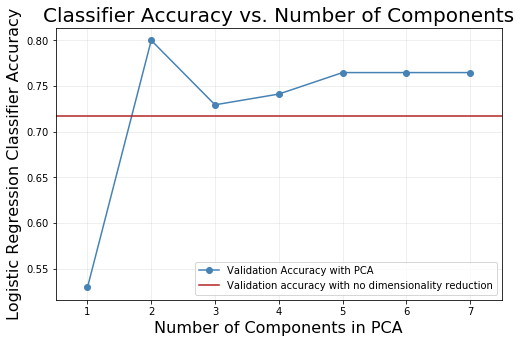

In [52]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
ax.plot(numComponents, validationAccuracies, color="steelblue", marker='o', label='Validation Accuracy with PCA')
ax.plot([0, 8], [validAcc_noPCA, validAcc_noPCA], color="firebrick", label='Validation accuracy with no dimensionality reduction')
ax.set_xlim([0.5,7.5])
ax.grid(alpha=0.25)
ax.set_xlabel("Number of Components in PCA", fontsize=16)
ax.set_ylabel("Logistic Regression Classifier Accuracy", fontsize=16)
ax.set_title("Classifier Accuracy vs. Number of Components", fontsize=20)
ax.legend(loc='lower right');

In the table below, we show the best hyperparameter settings and validation accuracies that were found during 5-fold cross validation for each number of components used in principle components analysis:

| Number of Components |   Alpha   | Validation Accuracy |
|----------------------|-----------|---------------------|
|          1           |   0.001   | 0.5294117647058824  |
|          2           |   100.0   |         0.8         |
|          3           |   100.0   | 0.7294117647058823  |
|          4           |   0.01    | 0.7411764705882353  |
|          5           |   0.01    | 0.7647058823529411  |
|          6           |   0.01    | 0.7647058823529411  |
|          7           |   0.01    | 0.7647058823529411  |
|        No PCA        |   0.01    | 0.7176470588235294  |

As apparent in the table above, the best validation accuracy that we achieved with a logistic regression classifier was when we used 2 principle components in PCA and a regularization strength (alpha) of 100.0.  These parameter settings yielded a validation accuracy of 0.80.  We were not surprised to find that the classifier was able to perform well with a small number of components, considering that some of the original features of our dataset are highly correlated (for example, values for the 'Avg Speed' feature are the exact values that would be obtained by dividing the 'Distance' feature by the 'Time' feature).  What did surprise us though was the best setting for the regularization strength, alpha.  Alpha=100.0 is a very large regularization strength, which would result in a model with higher bias.<br><br>

### Random Forest Classifier

$\quad$ Next, we analyzed the performance of a random forest classifier on our training data set.  The hyperparameters that we tuned for this classifier were the number of trees in the random forest, the maximum depth of the trees in the forest, and the minimum number of samples at a leaf in each tree.  We chose to tune theses parameters so that we would be able to directly tune the bias/variance tradeoff by adjusting variance in the individual trees (by means of limiting the tree depth and restricting when more subtrees can be formed) and by adjusting the number of trees in the ensemble (recalling that random forests have the classification strengths of a decision tree without the overfitting properties).  These hyperparameters where tuned by doing a gridsearch on a specified set of setting (denoted by the `params` variable in the code below).  Similar to the methodology used while experimenting with the logistic regression classifier, we used PCA on our feature set (with number of components in range 1-7) and obtained validation accuracies by means of 5-fold cross validation.  Code for this random forest classifier and the associated results are provided below:

In [53]:
base_classifier = RandomForestClassifier(random_state=123)

params = [{'n_estimators': [10, 50, 100], 'max_depth': [1, 5, 10], 'min_samples_leaf': [1, 5, 10]}]

# this performs 5-fold cross-validation with the above classifier and parameter options
gs_classifier = GridSearchCV(base_classifier, params, cv=5)

# number of axes for principle component analysis
numComponents = np.arange(1,8)

validationAccuracies = []
testAccuracies = []

print("|Number of Components| Number of Trees | Maximum Depth of Trees | Min Samples at Tree Leaves | Validation Accuracy |")
print("|--------------------|-----------------|------------------------|----------------------------|---------------------|")
for n in numComponents:
    pca = PCA(n_components=n, random_state=123)
    x_train_final = pca.fit_transform(x_train)
    gs_classifier.fit(x_train_final, y_train)
    validAcc = gs_classifier.best_score_
    validationAccuracies.append(validAcc)
    params = gs_classifier.best_params_
    print("|{:^20}|{:^17}|{:^24}|{:^28}|{:^21}|".format(n, params['n_estimators'], params['max_depth'], params['min_samples_leaf'], validAcc))
    
# Classifier without PCA
gs_classifier.fit(x_train, y_train)
validAcc_noPCA = gs_classifier.best_score_
params = gs_classifier.best_params_
print("|{:^20}|{:^17}|{:^24}|{:^28}|{:^21}|".format('No PCA', params['n_estimators'], params['max_depth'], params['min_samples_leaf'], validAcc_noPCA))


|Number of Components| Number of Trees | Maximum Depth of Trees | Min Samples at Tree Leaves | Validation Accuracy |
|--------------------|-----------------|------------------------|----------------------------|---------------------|
|         1          |       10        |           1            |             1              |  0.611764705882353  |
|         2          |       100       |           5            |             10             | 0.8705882352941177  |
|         3          |       10        |           5            |             10             | 0.8705882352941177  |
|         4          |       50        |           1            |             1              | 0.8588235294117647  |
|         5          |       50        |           1            |             10             | 0.8941176470588236  |
|         6          |       100       |           1            |             1              | 0.8823529411764706  |
|         7          |       50        |           1            

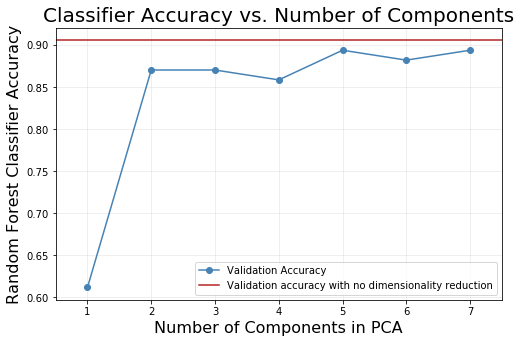

In [54]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
ax.plot(numComponents, validationAccuracies, color="steelblue", marker='o', label='Validation Accuracy')
ax.plot([0, 8], [validAcc_noPCA, validAcc_noPCA], color="firebrick", label='Validation accuracy with no dimensionality reduction')
ax.set_xlim([0.5,7.5])
ax.grid(alpha=0.25)
ax.set_xlabel("Number of Components in PCA", fontsize=16)
ax.set_ylabel("Random Forest Classifier Accuracy", fontsize=16)
ax.set_title("Classifier Accuracy vs. Number of Components", fontsize=20)
ax.legend(loc='lower right');

The best hyperparameter settings and validation accuracies that were found during 5-fold cross validation for each number of components used in principle components analysis are shown below:
 
 |Number of Components| Number of Trees | Maximum Depth of Trees | Min Samples at Tree Leaves | Validation Accuracy |
|--------------------|-----------------|------------------------|----------------------------|---------------------|
|         1          |       10        |           1            |             1              |  0.611764705882353  |
|         2          |       100       |           5            |             10             | 0.8705882352941177  |
|         3          |       10        |           5            |             10             | 0.8705882352941177  |
|         4          |       50        |           1            |             1              | 0.8588235294117647  |
|         5          |       50        |           1            |             10             | 0.8941176470588236  |
|         6          |       100       |           1            |             1              | 0.8823529411764706  |
|         7          |       50        |           1            |             1              | 0.8941176470588236  |
|       No PCA       |       10        |           5            |             1              | 0.9058823529411765  |
 
The best validation accuracy that we achieved with a random forest classifier was when we used our original feature set for training (no dimensionality reduction), 10 decision trees in the ensemble, a maximum decision tree depth of 5, and 1 for the minimum number of samples at the decision tree leaves.  These hyperparameter settings yielded a validation accuracy of 0.9059.  By having the minimum number of sample at the leaves of decision tree be 1 and a maximum depth of 5, this allowed for high variance in the individual decision trees.  Also, no bias was added to the decision tree classifiers by means of dimensionality reduction.  However, by combining these potentially overfitted trees into a random forest ensemble, the risk of overfitting was reduced.  Applying PCA with 1 component resulting in a random forest classifier with validation accuracy significantly worse than any of the other classifiers.<br><br>

### Multi-Layer Perceptron

$\quad$ The last type of classification algorithm that we experimented with was a multi-layer perceptron.  Along with performing various levels of dimenstionality reduction using Principle Component Analysis, as done with the previous classifiers, we tuned the number of hidden layers in the multi-layer perceptron, the number of units in each layer of the multi-layer perceptron, and the L2 regularization strength, `alpha`.  These hyperparameter settings were tuned in a grid serach and we analyzed the performance of these settings by obtaining held out accuracy estimates using 5-fold cross validation.  In our grid search, we experimented with multi-layer perceptrons with 1 and 2 hidden layers and `alpha` values of 0.000001, 0.00001, 0.0001, and 0.001.  The multi-layer perceptron with a single hidden layer was tested with 1, 2, 5, 10, and 50 units in the hidden layer, while the multi-layer perceptron with a two hidden layers was tested with 1, 2, 5, 10, and 50 units in the first hidden layer and 1, 2, 5, 10, and 50 units in the second hidden layer for each unit count in the first layer.  Code for our multi-layer perceptron classifier and the associated results are provided below:

In [30]:
base_classifier = MLPClassifier(random_state=123, max_iter=1000)

units = [1, 2, 5, 10, 50]
oneples = [(w) for w in units]
tuples = [(w1, w2) for w1 in units for w2 in units]

params = [{'hidden_layer_sizes': oneples + tuples, 'alpha': [0.000001, 0.00001, 0.0001, 0.001]}]

# this performs 5-fold cross-validation with the above classifier and parameter options
gs_classifier = GridSearchCV(base_classifier, params, cv=5)

# number of axes for principle component analysis
numComponents = np.arange(1,8)

validationAccuracies = []

print("| Number of Components | Hidden Layer Sizes |   Alpha   | Validation Accuracy |")
print("|----------------------|--------------------|-----------|---------------------|")
for n in numComponents:
    pca = PCA(n_components=n, random_state=123)
    x_train_final = pca.fit_transform(x_train)
    gs_classifier.fit(x_train_final, y_train)
    validAcc = gs_classifier.best_score_
    validationAccuracies.append(validAcc)
    params = gs_classifier.best_params_
    print("|{:^22}|{:^20}|{:^11}|{:^21}|".format(n, str(params['hidden_layer_sizes']), params['alpha'], validAcc))
    
# Classifier without PCA
gs_classifier.fit(x_train, y_train)
validAcc_noPCA = gs_classifier.best_score_
print("|{:^22}|{:^20}|{:^11}|{:^21}|".format('No PCA', str(params['hidden_layer_sizes']), params['alpha'], validAcc_noPCA))

| Number of Components | Hidden Layer Sizes |   Alpha   | Validation Accuracy |
|----------------------|--------------------|-----------|---------------------|
|          1           |      (50, 10)      |   1e-06   | 0.6470588235294118  |
|          2           |       (5, 5)       |   1e-06   | 0.8117647058823529  |
|          3           |         50         |   1e-06   | 0.8117647058823529  |
|          4           |         50         |   1e-06   | 0.8117647058823529  |
|          5           |      (10, 2)       |   0.001   | 0.7529411764705882  |
|          6           |      (10, 5)       |   1e-05   | 0.7058823529411765  |
|          7           |       (5, 2)       |   1e-06   | 0.8705882352941177  |
|        No PCA        |       (5, 2)       |   1e-06   | 0.8588235294117647  |


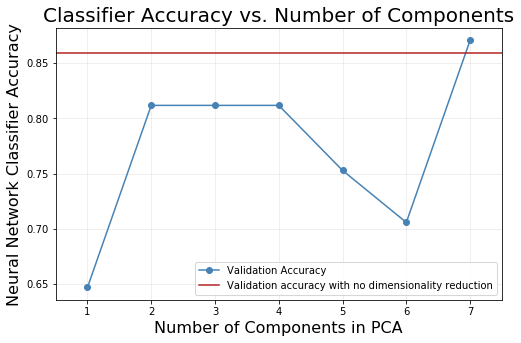

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
ax.plot(numComponents, validationAccuracies, color="steelblue", marker='o', label='Validation Accuracy')
ax.plot([0, 8], [validAcc_noPCA, validAcc_noPCA], color="firebrick", label='Validation accuracy with no dimensionality reduction')
ax.set_xlim([0.5,7.5])
ax.set_xlabel("Number of Components in PCA", fontsize=16)
ax.set_ylabel("Neural Network Classifier Accuracy", fontsize=16)
ax.set_title("Classifier Accuracy vs. Number of Components", fontsize=20)
ax.grid(alpha=0.25)
ax.legend(loc='lower right');

The best hyperparameter settings and validation accuracies that were found during 5-fold cross validation for each number of components used in principle components analysis are shown below:

| Number of Components | Hidden Layer Sizes |   Alpha   | Validation Accuracy |
|----------------------|--------------------|-----------|---------------------|
|          1           |      (50, 10)      |   1e-06   | 0.6470588235294118  |
|          2           |       (5, 5)       |   1e-06   | 0.8117647058823529  |
|          3           |         50         |   1e-06   | 0.8117647058823529  |
|          4           |         50         |   1e-06   | 0.8117647058823529  |
|          5           |      (10, 2)       |   0.001   | 0.7529411764705882  |
|          6           |      (10, 5)       |   1e-05   | 0.7058823529411765  |
|          7           |       (5, 2)       |   1e-06   | 0.8705882352941177  |
|        No PCA        |       (5, 2)       |   1e-06   | 0.8588235294117647  |

The best validation accuracy that we achieved with a multi-layer perceptron was when we used applied principle component analysis with 7 componrnts to our full feature set, 2 hidden layers (the first one with 5 units and the second with 2 units), and a L2 regularization strength, alpha, of 0.000001.  The multi-layer perceptron with these settings yielded a validation accuracy of 0.8706.<br><br>

## Testing our Classifier

$\quad$ After experimenting with logistic regression, random forest, and multi-layer perceptron classifiers, we found the best classifier to be a random forest classifier with 10 decision trees in the ensemble, a maximum decision tree depth of 5, 1 for the minimum number of samples at the decision tree leaves, and trained without dimensionality reduction. This classifier achieved the best validation accuracy during 5-fold cross validation, 0.9059.  In the code cell below, the testing accuracy of this model is determined.

In [82]:
# initialize random forest classifier with our best found hyperparameter settings
bestClassifier = RandomForestClassifier(n_estimators=10, max_depth=5, min_samples_leaf=1)

# train the random forest classifier on all of the training data
bestClassifier.fit(x_train, y_train)

x_all = dfData.iloc[0:, 0:7].values
y_all = dfData.iloc[0:, 7].values

# obtain accuracy on held out test data
print("Testing Accuracy of Best Classifier: {}".format(bestClassifier.score(x_all, y_all)))

Testing Accuracy of Best Classifier: 0.9905660377358491


## Error Analysis

$\quad$ In this section, we examine that errors that the best classifier made when predicting the labels of the test data.  Please note that `random_state` was set so that our analysis would be consistent with the misclassifications upon re-running our code.

### Analyzing Misclassified Instances

In the code cell below, instances from the testing data that are misclassified and their assciated feature values are printed.

In [38]:
# initialize random forest classifier with our best found hyperparameter settings
bestClassifier = RandomForestClassifier(n_estimators=10, max_depth=5, min_samples_leaf=1, random_state=321)

# train the random forest classifier on all of the training data
bestClassifier.fit(x_train, y_train)

# print testing instances that have predicted labels different than true labels
for x,y,i in zip(x_test, y_test, range(0, len(dfData))):
    if bestClassifier.predict([x]) != y:
        print("Instance {} misclassified".format(i))
        print("\tInstance feature values:")
        for featureName, featureValue in zip(dfData.columns, x):
            print("\t{}: {}".format(featureName, featureValue))
        print("Predicted Label: {}".format(bestClassifier.predict([x])[0]))
        print("True Label: {}\n".format(y))

Instance 8 misclassified
	Instance feature values:
	Distance (Miles): 13.06
	Calories: 534.0
	Time (minutes): 59.0
	Avg Speed: 13.3
	Max Speed: 26.4
	Elev Gain: 1106.0
	Elev Loss: 1109.0
Predicted Label: 0
True Label: 1

Instance 11 misclassified
	Instance feature values:
	Distance (Miles): 21.34
	Calories: 841.0
	Time (minutes): 103.3
	Avg Speed: 12.4
	Max Speed: 30.2
	Elev Gain: 3146.0
	Elev Loss: 3128.0
Predicted Label: 0
True Label: 1



Both instances that were incorrectly classified in our testing data are mountain bike rides that were misclassified as road bike rides.  The reason we suspect that instance 8 was misclassified was because of its feature values for 'Distance', 'Elev Gain', and 'Elev Loss'.  Looking through the data, there were several road bike rides that share similar feautre values for these features, so the instances was likely mislabeled to to these similarities.  A feature that does make this instance characteristic of a mountain bike ride is the 'Avg Speed' feature.  Average speed for mountain bike rides are commonly less than that of road bike rides.  The reason we suspect that instance 11 was misclassified was because of the 'Elev Gain' and 'Elev Loss' feature values.  The road bike ride instances in this dataset typically have larger values, such as the 3146 ft of 'Elev Gain' and 3128 ft of 'Elev Loss' that this mountain bike instance has.  Similar to instance 8 though, the 'Avg Speed' feature of instance 11 is low for a road bike ride, however this was missed by the classifier.  After looking at the misclassified instances from our testing dataset, it is evident that the classifier may have been able to perform better if it learned to assign more weight to the 'Avg Speed' feature.

### Analysis of Confusion Matrix

In [39]:
confusion = confusion_matrix(y_test, bestClassifier.predict(x_test))

In [100]:
print("Confusion Matrix:\n")
print("\t\t\tPredicted Bike Ride Type")
print("\t\t\tMountain\tRoad")
for i, row in enumerate(confusion):
    if i == 0:
        print("Actual Label\tMountain  {}\t\t{}".format(row[0], row[1]))
    else:
        print("\t\tRoad\t  {}\t\t{}".format(row[0], row[1]))
print()

Confusion Matrix:

			Predicted Bike Ride Type
			Mountain	Road
Actual Label	Mountain  10		0
		Road	  2		9



### Would we have benefitted from more data?

$\quad$ One of the concerns we had prior to starting this project was that we did not have a sufficient number of instances in our training set.  We were pleased to see the validation accuries and final test accuracies that we achieved after experimenting with various classifiers, but were still curious as to whether we would have benefitted from having more training data.  To help answer this question, we decided to plot a learning curve for our data using our final classifier.

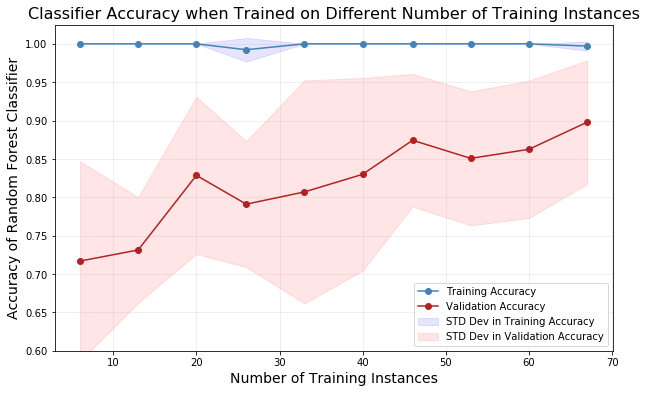

In [99]:
bestClassifier = RandomForestClassifier(n_estimators=10, max_depth=5, min_samples_leaf=1)

trainSize, trainAccuracy, validAccuracy = learning_curve(estimator=bestClassifier, X=x_train, y=y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=5)
trainingMean = np.mean(trainAccuracy, axis=1)
trainingSTDdeviation = np.std(trainAccuracy, axis=1)
validationMean = np.mean(validAccuracy, axis=1)
validationSTDdeviation = np.std(validAccuracy, axis=1)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
ax.plot(trainSize, trainingMean, color='steelblue', marker='o', label='Training Accuracy')
ax.fill_between(trainSize, trainingMean+trainingSTDdeviation, trainingMean-trainingSTDdeviation, alpha=0.1, color='blue', label='STD Dev in Training Accuracy')
ax.plot(trainSize, validationMean, color='firebrick', marker='o', label='Validation Accuracy')
ax.fill_between(trainSize, validationMean+validationSTDdeviation, validationMean-validationSTDdeviation, alpha=0.1, color='red', label='STD Dev in Validation Accuracy')
ax.set_xlabel('Number of Training Instances', size=14)
ax.set_ylabel('Accuracy of Random Forest Classifier', size=14)
ax.set_title("Classifier Accuracy when Trained on Different Number of Training Instances", fontsize=16)
ax.set_ylim([.6, 1.025])
ax.legend(loc='lower right')
ax.grid(alpha=0.25);

Observing the Learning Curve above, the cureved for training and validation accuracy have yet to converge, indicating that our model have benefit from having more training instances.  Another notable aspect from this Learning Curve is the rate at which the two cureves are converging.  The slow convergence of these two lines leads us to believe that our model has a high variance.  High variance in our model is also illustrated by the amount of standard deviation in the validation accuracy, as validation accuracy appears to be highly dependent on which training instances were used in each fold of the 5-fold cross validation that we used.<br><br>